# Alta Adoção de Telemedicina: Análise e Predição

Predição de alta adoção de telemedicina a partir de características regionais e demográficas

## Integrantes: 

ERICK MOLINA - RM 553852

FELIPE CASTRO SALAZAR - RM 553464

MARCELO VIEIRA DE MELO - RM 552953

RAYARA AMARO FIGUEIREDO - RM 552635

VICTOR RODRIGUES - RM 554158


Neste projeto será utilizado o dataset `TMEDTREND_PUBLIC_250827.csv`, que reúne informações agregadas sobre beneficiários do Medicare/Medicaid nos EUA. Cada registro descreve um grupo populacional definido por ano, trimestre, região (estado) e características demográficas como idade, sexo, raça e classificação rural/urbana, além de apresentar o indicador `Pct_Telehealth`, que representa o percentual de uso de telemedicina naquele grupo.

O objetivo principal é entender padrões de uso de telemedicina e, em seguida, verificar se é possível prever quais grupos apresentam alta adoção. Para isso, o valor contínuo `Pct_Telehealth` será transformado em uma variável binária chamada `High_Adoption`, onde:

- 1 (Alta adoção): grupos no top 25% de `Pct_Telehealth` dentro de cada trimestre;

- 0 (Baixa adoção): demais grupos do trimestre.

Após essa definição, será realizada uma análise exploratória dos dados (EDA) para identificar distribuições, correlações e tendências por região e perfil demográfico. Em seguida, aplicaremos modelos de classificação supervisionada para prever `High_Adoption` a partir das variáveis regionais e demográficas, avaliando o desempenho com métricas apropriadas.

Assim, o projeto combina insights descritivos sobre adoção de telemedicina com a construção de um modelo preditivo capaz de indicar grupos com maior probabilidade de alta utilização desse serviço.

### 1) Carregamento e visão geral do dataset

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/Users/rayaraamaro/Documents/Estudos/FIAP/3 ANO/ML and AI/Challenge/Challenge-Telehelth/TMEDTREND_PUBLIC_250827.csv")

df.head()
df.shape
df.dtypes


Year                          int64
quarter                      object
Bene_Geo_Desc                object
Bene_Mdcd_Mdcr_Enrl_Stus     object
Bene_Race_Desc               object
Bene_Sex_Desc                object
Bene_Mdcr_Entlmt_Stus        object
Bene_Age_Desc                object
Bene_RUCA_Desc               object
Total_Bene_TH_Elig          float64
Total_PartB_Enrl            float64
Total_Bene_Telehealth       float64
Pct_Telehealth              float64
dtype: object

- Análise:
O dataset possui 31.304 registros e 13 variáveis. As colunas se dividem entre atributos categóricos (características regionais, temporais e demográficas) e atributos numéricos (quantidades absolutas de elegíveis, inscritos e usuários de telemedicina, além do percentual de uso). Essa estrutura é adequada para análises comparativas por grupos e também para a formulação de um problema de classificação binária com base no percentual de uso (Pct_Telehealth).

### 2) Verificação de valores faltantes (missing values)

In [3]:
missing = df.isna().sum().sort_values(ascending=False)
missing


Pct_Telehealth              3377
Total_Bene_Telehealth       3375
Total_Bene_TH_Elig          3314
Total_PartB_Enrl            3314
Year                           0
quarter                        0
Bene_Geo_Desc                  0
Bene_Mdcd_Mdcr_Enrl_Stus       0
Bene_Race_Desc                 0
Bene_Sex_Desc                  0
Bene_Mdcr_Entlmt_Stus          0
Bene_Age_Desc                  0
Bene_RUCA_Desc                 0
dtype: int64

- Análise:
Observamos a presença relevante de valores ausentes nas variáveis numéricas, principalmente em Pct_Telehealth e nos totais absolutos. Isso indica que parte dos grupos regionais/demográficos não teve informação preenchida ou consolidada.

### 3) Distribuição do percentual de telemedicina (target)

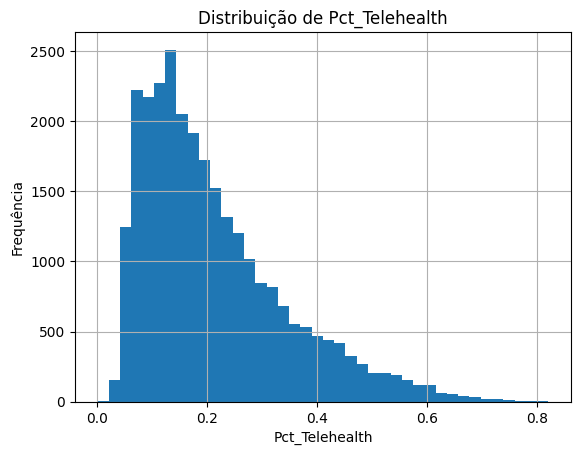

In [4]:
import matplotlib.pyplot as plt

plt.figure()
df['Pct_Telehealth'].dropna().hist(bins=40)
plt.title('Distribuição de Pct_Telehealth')
plt.xlabel('Pct_Telehealth')
plt.ylabel('Frequência')
plt.show()


- Análise:
A variável Pct_Telehealth apresenta distribuição assimétrica à direita. A maior parte dos grupos possui adoção moderada (em torno de 10% a 30%), enquanto um conjunto menor de registros alcança percentuais muito elevados. Esse padrão sugere heterogeneidade significativa entre regiões e perfis demográficos, reforçando a relevância de investigar fatores associados à alta adoção.

### 4) Evolução do uso ao longo dos anos

<Figure size 640x480 with 0 Axes>

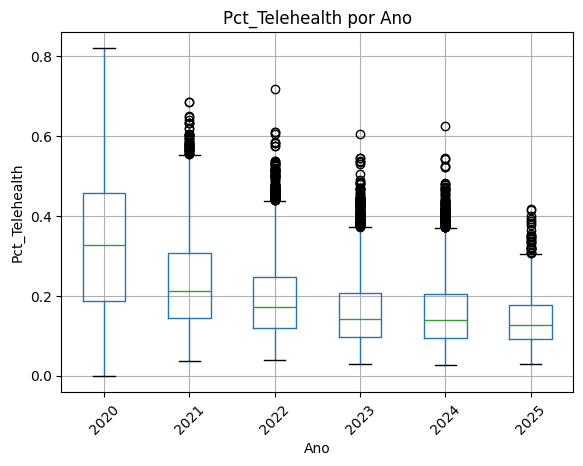

In [5]:
plt.figure()
df.boxplot(column='Pct_Telehealth', by='Year', rot=45)
plt.title('Pct_Telehealth por Ano')
plt.suptitle('')
plt.xlabel('Ano')
plt.ylabel('Pct_Telehealth')
plt.show()


<Figure size 640x480 with 0 Axes>

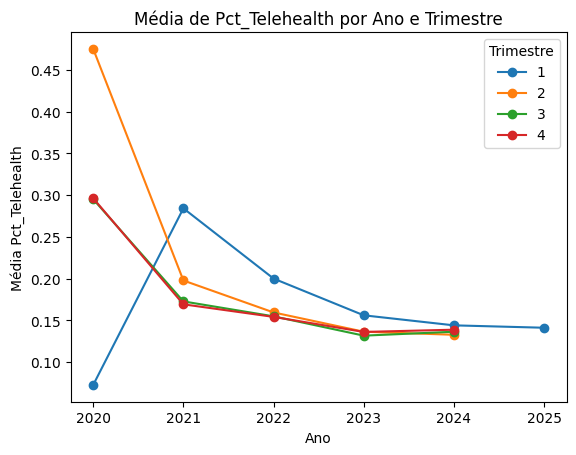

In [6]:
df_q = df[df['quarter']!='Overall'].copy()
mean_yq = df_q.groupby(['Year','quarter'])['Pct_Telehealth'].mean().unstack()

plt.figure()
mean_yq.plot(kind='line', marker='o')
plt.title('Média de Pct_Telehealth por Ano e Trimestre')
plt.xlabel('Ano')
plt.ylabel('Média Pct_Telehealth')
plt.legend(title='Trimestre')
plt.show()


Análise:
A análise por ano mostra pico de adoção em 2020, seguido por queda progressiva e estabilização nos anos seguintes. Esse resultado é consistente com o contexto histórico de expansão da telemedicina durante a pandemia de COVID-19 e redução gradual após o período crítico. A tendência temporal é um fator importante e deve ser considerada como feature.

### 5) Correlação entre variáveis numéricas

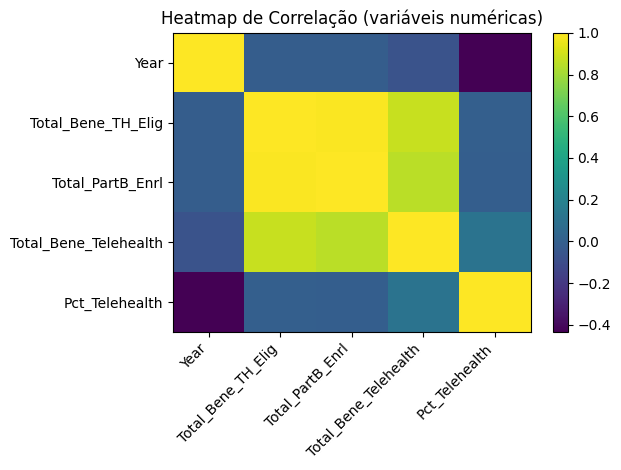

,Year,Total_Bene_TH_Elig,Total_PartB_Enrl,Total_Bene_Telehealth,Pct_Telehealth
Year,1.000000,-0.009439,-0.012700,-0.065628,-0.435222
Total_Bene_TH_Elig,-0.009439,1.000000,0.993843,0.879533,-0.000474
Total_PartB_Enrl,-0.012700,0.993843,1.000000,0.851072,-0.007942
Total_Bene_Telehealth,-0.065628,0.879533,0.851072,1.000000,0.108600
Pct_Telehealth,-0.435222,-0.000474,-0.007942,0.108600,1.000000


In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure()
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Heatmap de Correlação (variáveis numéricas)')
plt.colorbar()
plt.tight_layout()
plt.show()

corr


- Explicação do gráfico:
A correlação apresentada foi calculada apenas entre variáveis numéricas pois o coeficiente de Pearson exige valores contínuos. No dataset, a maior parte das colunas é categórica (ex.: raça, sexo, faixa etária, RUCA), e aplicar Pearson diretamente nesse tipo de variável não é válido, pois categorias não possuem ordem numérica natural. Para avaliar associação envolvendo variáveis categóricas, são necessárias métricas específicas, como Cramér’s V para categoria–categoria ou ANOVA/eta² para categoria–numérica. Portanto, a correlação numérica foi usada como primeira visão de dependência linear apenas entre os atributos quantitativos.

- Análise:
As variáveis de totais absolutos exibem correlação muito alta entre si, indicando que representam escalas semelhantes da população beneficiária. Já Pct_Telehealth apresenta baixa correlação com os totais, sugerindo que a adoção percentual não é determinada apenas pelo número de beneficiários, mas por características qualitativas. A correlação negativa com o ano reforça a tendência temporal de redução após 2020.

### 6) Adoção média por grupos demográficos / regionais

#### 6.1 Rural vs Urbano (RUCA)

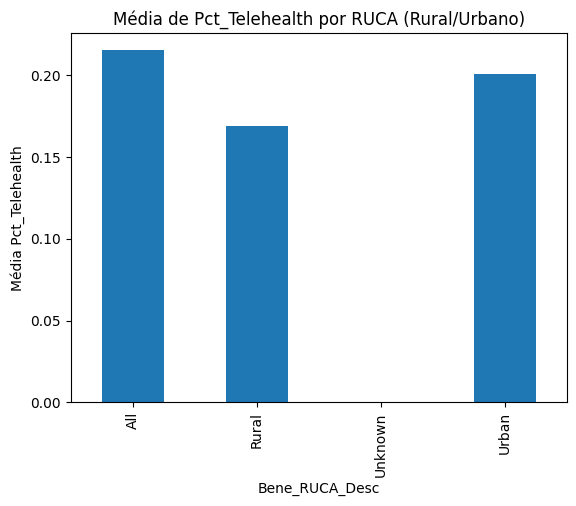

In [8]:
means_ruca = df.groupby('Bene_RUCA_Desc')['Pct_Telehealth'].mean()

plt.figure()
means_ruca.plot(kind='bar')
plt.title('Média de Pct_Telehealth por RUCA (Rural/Urbano)')
plt.ylabel('Média Pct_Telehealth')
plt.show()


- Análise:
A variável Bene_RUCA_Desc utiliza a classificação RUCA (Rural–Urban Commuting Area), que distingue se os beneficiários vivem em áreas urbanas ou rurais com base em características de urbanização e padrões de deslocamento. No dataset também aparece a categoria “All”, que representa o valor agregado geral, isto é, o total sem separar por RUCA (juntando rural + urbano), funcionando como referência comparativa.

    No gráfico 6.1, observa-se que a média de Pct_Telehealth é maior em áreas Urbanas do que em áreas Rurais, enquanto “All” fica entre esses valores por ser a média global. Esse resultado sugere que regiões urbanas tendem a adotar mais telemedicina, possivelmente por maior acesso tecnológico e infraestrutura de saúde digital, indicando que o fator rural/urbano é relevante para explicar diferenças de adoção no modelo preditivo.

#### 6.2 Faixa etária

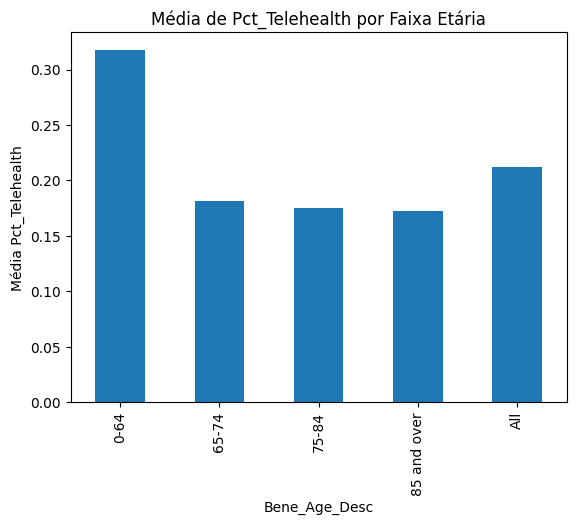

In [9]:
means_age = df.groupby('Bene_Age_Desc')['Pct_Telehealth'].mean()

plt.figure()
means_age.plot(kind='bar')
plt.title('Média de Pct_Telehealth por Faixa Etária')
plt.ylabel('Média Pct_Telehealth')
plt.show()


- Análise:
Observa-se maior uso de telemedicina na faixa etária 0–64, com redução nas faixas acima de 65 anos. Esse padrão sugere que idade influencia a adoção, possivelmente por familiaridade tecnológica ou preferências de atendimento presenciais em idosos.

#### 6.3 Sexo

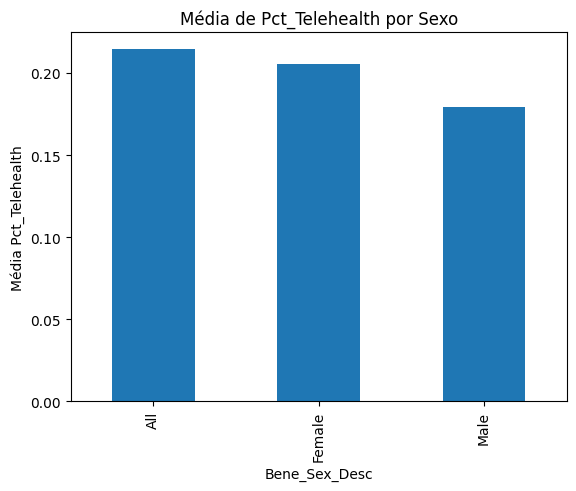

In [10]:
means_sex = df.groupby('Bene_Sex_Desc')['Pct_Telehealth'].mean()

plt.figure()
means_sex.plot(kind='bar')
plt.title('Média de Pct_Telehealth por Sexo')
plt.ylabel('Média Pct_Telehealth')
plt.show()


- Análise:
Os resultados indicam adoção levemente superior entre mulheres em relação aos homens. Embora a diferença não seja extrema, sexo pode contribuir como variável explicativa complementar.

#### 6.4 Raça

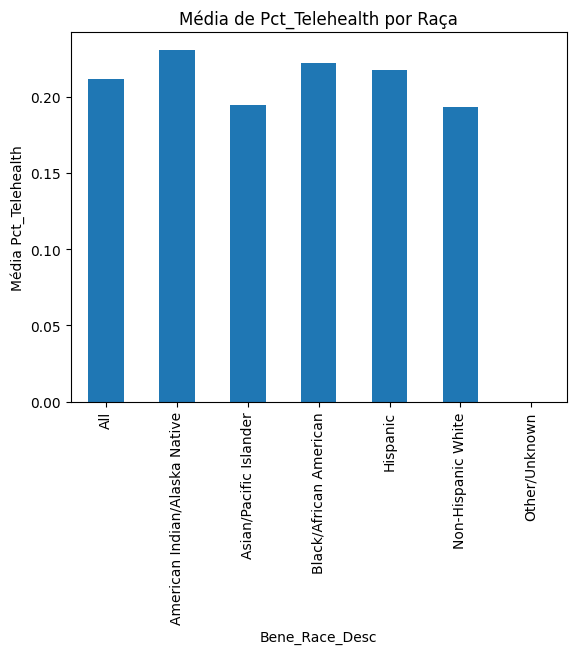

In [11]:
means_race = df.groupby('Bene_Race_Desc')['Pct_Telehealth'].mean()

plt.figure()
means_race.plot(kind='bar')
plt.title('Média de Pct_Telehealth por Raça')
plt.ylabel('Média Pct_Telehealth')
plt.show()


- Análise:
A adoção de telemedicina varia entre grupos raciais. Alguns grupos apresentam médias mais altas que a população geral, enquanto outros permanecem abaixo. Esse comportamento reforça a necessidade de incluir raça como feature no modelo, além de tratar adequadamente categorias com dados ausentes.

Resumo dos insights:

1. Pct_Telehealth é bem variado, com poucos grupos muito altos.

2. 2020 foi o pico, depois estabilizou mais baixo.

3. Urbanos usam mais que rurais.

4. Pessoas mais jovens usam mais.

5. Mulheres usam um pouco mais que homens.

6. Existe diferença por raça.

7. Totais absolutos são colineares, mas não explicam o percentual sozinhos.

### Etapa 1 — Limpeza básica dos dados

In [15]:
# 1) remover linhas sem target
df_clean = df.dropna(subset=["Pct_Telehealth"]).copy()

# 2) remover registros "Overall" (não são trimestres reais)
df_clean = df_clean[df_clean["quarter"] != "Overall"].copy()

df.shape, df_clean.shape


((31304, 13), (22547, 13))

- Análise:
Para iniciar o pré-processamento, foram removidos registros com valores ausentes em Pct_Telehealth, pois essa variável é essencial para a criação do target de alta/baixa adoção. Também foram excluídas linhas em que quarter = "Overall", já que representam valores agregados anuais e não seguem a lógica do problema por trimestre. Após essa limpeza, o conjunto ficou com 22.547 registros válidos para modelagem

### Etapa 2 — Criação do Target High_Adoption

Para cada ano + trimestre, vamos marcar como alta adoção (1) o grupo que estiver no top 25% de Pct_Telehealth daquele trimestre.

In [16]:
# 3) calcular percentil 75 por ano + trimestre
p75 = (
    df_clean.groupby(["Year", "quarter"])["Pct_Telehealth"]
    .quantile(0.75)
    .rename("p75_trim")
    .reset_index()
)

# 4) juntar o percentil ao dataframe e criar High_Adoption
df_clean = df_clean.merge(p75, on=["Year", "quarter"], how="left")
df_clean["High_Adoption"] = (df_clean["Pct_Telehealth"] >= df_clean["p75_trim"]).astype(int)

df_clean[["Year","quarter","Pct_Telehealth","p75_trim","High_Adoption"]].head()


,Year,quarter,Pct_Telehealth,p75_trim,High_Adoption
0,2020,1,0.0694,0.0875,0
1,2020,1,0.0991,0.0875,1
2,2020,1,0.0616,0.0875,0
3,2020,1,0.0633,0.0875,0
4,2020,1,0.0790,0.0875,0


In [17]:
class_counts = df_clean["High_Adoption"].value_counts().sort_index()
class_pct = df_clean["High_Adoption"].value_counts(normalize=True).sort_index()*100

class_counts, class_pct


(High_Adoption
 0    16905
 1     5642
 Name: count, dtype: int64,
 High_Adoption
 0    74.976715
 1    25.023285
 Name: proportion, dtype: float64)

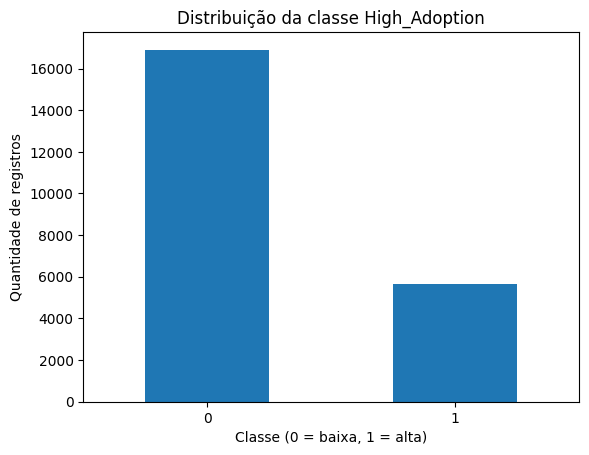

In [18]:
import matplotlib.pyplot as plt

plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribuição da classe High_Adoption")
plt.xlabel("Classe (0 = baixa, 1 = alta)")
plt.ylabel("Quantidade de registros")
plt.xticks(rotation=0)
plt.show()


- Análise:
A variável alvo do projeto foi criada a partir de Pct_Telehealth seguindo a regra definida no objetivo. Para cada combinação de ano e trimestre, calculou-se o percentil 75 de Pct_Telehealth, definindo como Alta adoção (1) os registros acima ou iguais a esse limiar e como Baixa adoção (0) os demais. A distribuição da nova variável High_Adoption resultou em aproximadamente 75% de classe 0 e 25% de classe 1, confirmando que o critério do top 25% foi aplicado corretamente e não gerou desbalanceamento inesperado.

### Análise da Alta Adoção de Telemedicina por Grupos Demográficos e Regionais

#### Alta Adoção (High_Adoption)

In [19]:
# já com df_clean e High_Adoption criados

def high_rate_bar(col, title):
    rates = df_clean.groupby(col)["High_Adoption"].mean().sort_values(ascending=False)
    plt.figure()
    rates.plot(kind="bar")
    plt.title(title)
    plt.ylabel("Proporção de alta adoção (classe=1)")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return rates


#### Alta adoção por RUCA (Rural/Urbano)

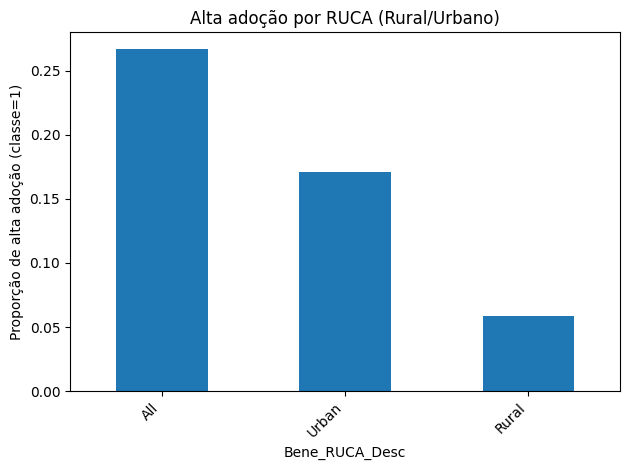

Bene_RUCA_Desc
All      0.266750
Urban    0.171106
Rural    0.058292
Name: High_Adoption, dtype: float64

In [20]:
rates_ruca = high_rate_bar("Bene_RUCA_Desc", "Alta adoção por RUCA (Rural/Urbano)")
rates_ruca


- Análise:
A variável RUCA separa regiões urbanas e rurais. Observa-se que a proporção de grupos classificados como alta adoção é significativamente maior em áreas urbanas (~17%) do que em áreas rurais (~6%). Isso reforça que contexto urbano está associado a maior chance de alta adoção de telemedicina, possivelmente por maior acesso tecnológico e infraestrutura de saúde digital. A categoria “All” funciona como referência geral do conjunto

#### Alta adoção por faixa etária

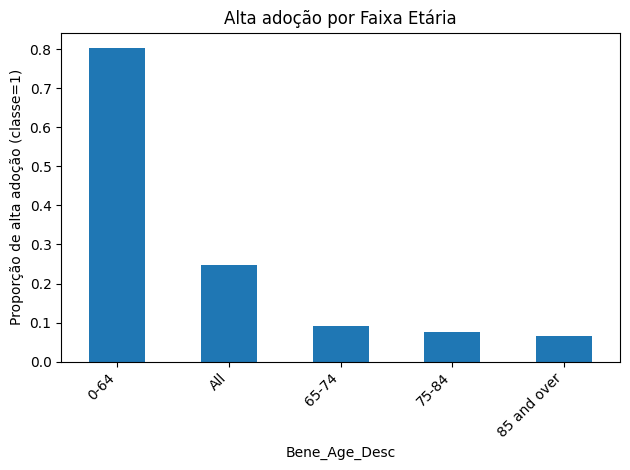

Bene_Age_Desc
0-64           0.801453
All            0.247797
65-74          0.092010
75-84          0.076675
85 and over    0.065375
Name: High_Adoption, dtype: float64

In [21]:
rates_age = high_rate_bar("Bene_Age_Desc", "Alta adoção por Faixa Etária")
rates_age


- Análise:
A proporção de alta adoção é extremamente concentrada na faixa etária 0–64, onde cerca de 80% dos registros aparecem no top 25%. Já as faixas acima de 65 anos apresentam proporções muito inferiores (entre 6% e 9%). Isso indica forte influência da idade na adoção de telemedicina, com maior probabilidade de alta adoção entre populações mais jovens.

#### Alta adoção por sexo

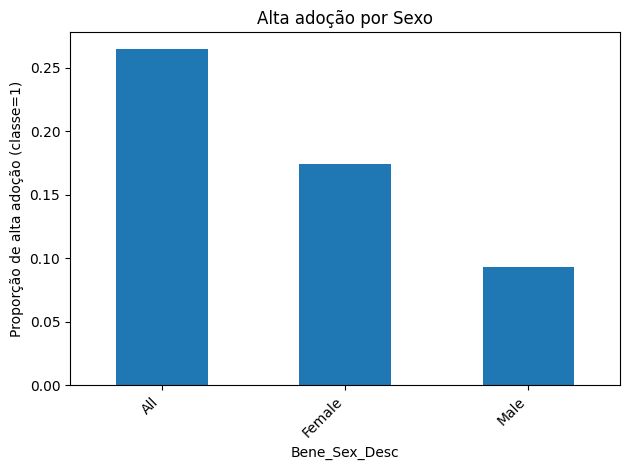

Bene_Sex_Desc
All       0.264637
Female    0.174334
Male      0.092817
Name: High_Adoption, dtype: float64

In [22]:
rates_sex = high_rate_bar("Bene_Sex_Desc", "Alta adoção por Sexo")
rates_sex


- Análise:
Grupos femininos apresentam maior proporção de alta adoção (~17%) quando comparados aos masculinos (~9%). Embora o sexo não seja o fator mais determinante, ele contribui para explicar a variação de alta adoção entre os grupos analisados.

#### Alta adoção por raça

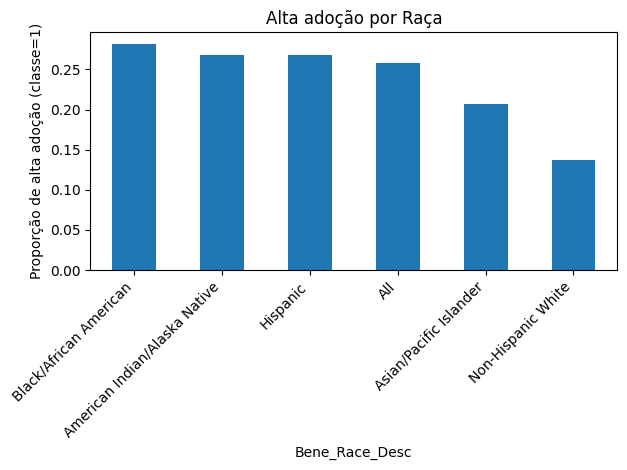

Bene_Race_Desc
Black/African American           0.282051
American Indian/Alaska Native    0.268519
Hispanic                         0.268132
All                              0.257852
Asian/Pacific Islander           0.207478
Non-Hispanic White               0.137729
Name: High_Adoption, dtype: float64

In [23]:
rates_race = high_rate_bar("Bene_Race_Desc", "Alta adoção por Raça")
rates_race


- Análise:
A variável raça apresenta diferenças relevantes na proporção de alta adoção. Grupos Black/African American, Hispanic e American Indian/Alaska Native aparecem com maior frequência no top 25% de adoção (~27–28%), enquanto Non-Hispanic White possui proporção menor (~14%). Isso mostra que fatores raciais também estão associados à probabilidade de alta adoção, justificando seu uso como feature no modelo.

Resumo dos insights

1. Urbanos têm muito mais chance de alta adoção que rurais.

2. 0–64 anos é o grupo disparado mais forte em alta adoção.

3. Mulheres > homens em probabilidade de alta adoção.

4. Existe diferença por raça, com alguns grupos aparecendo mais no top 25%.

### Etapa 3 - Pré-processamento para Machine Learning

#### Separando X e y (sem vazamento)

In [32]:
target = "High_Adoption"

# colunas que não podem entrar como feature (vazamento)
drop_cols = ["Pct_Telehealth", "p75_trim"]

X = df_clean.drop(columns=drop_cols + [target])
y = df_clean[target]



- Análise:
Nesta etapa, definimos as variáveis explicativas (X) e o target (y). Para evitar vazamento de informação, removemos Pct_Telehealth e p75_trim, pois ambos estão diretamente relacionados à construção do target High_Adoption. Assim, garantimos que o modelo aprenda somente a partir de características regionais, temporais, demográficas e totais populacionais, sem acesso indireto ao valor de adoção real.

#### Separando treino e teste

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # mantém 75/25 nas duas partes
)

X_train.shape, X_test.shape


((18037, 12), (4510, 12))

- Análise:
O conjunto foi dividido em dados de treino (80%) e teste (20%) usando train_test_split. O parâmetro stratify=y foi aplicado para preservar a proporção original das classes (aprox. 75% baixa adoção e 25% alta adoção) em ambos os subconjuntos. Isso evita distorções na avaliação do modelo.

#### One-Hot Encoding nas categóricas (pipeline)

In [33]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = ["Year", "Total_Bene_TH_Elig", "Total_PartB_Enrl", "Total_Bene_Telehealth"]
cat_cols = [
    "quarter", "Bene_Geo_Desc", "Bene_Mdcd_Mdcr_Enrl_Stus",
    "Bene_Race_Desc", "Bene_Sex_Desc", "Bene_Mdcr_Entlmt_Stus",
    "Bene_Age_Desc", "Bene_RUCA_Desc"
]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ]
)


- Análise: Como modelos de ML não lidam diretamente com variáveis categóricas em texto, aplicamos One-Hot Encoding para transformar cada categoria em colunas binárias (0/1). Esse processo foi implementado dentro de um ColumnTransformer. Para as variáveis numéricas, utilizamos padronização com StandardScaler, colocando todas na mesma escala (média 0 e desvio 1), o que é importante para modelos lineares como a Regressão Logística. O parâmetro handle_unknown="ignore" foi mantido para garantir robustez caso apareçam categorias novas no conjunto de teste.

### Treinar o modelo (Logistic Regression)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

log_reg = LogisticRegression(max_iter=2000, class_weight="balanced")

baseline_model = Pipeline([
    ("preprocess", preprocess),
    ("model", log_reg)
])

baseline_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['quarter', 'Bene_Geo_Desc',
                                                   'Bene_Mdcd_Mdcr_Enrl_Stus',
                                                   'Bene_Race_Desc',
                                                   'Bene_Sex_Desc',
                                                   'Bene_Mdcr_Entlmt_Stus',
                                                   'Bene_Age_Desc',
                                                   'Bene_RUCA_Desc']),
                                                 ('num', StandardScaler(),
                                                  ['Year', 'Total_Bene_TH_Elig',
                                                   'Total_PartB_Enrl',
                                                   'Total_Bene_Telehealth'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [35]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba)
}

cm = confusion_matrix(y_test, y_pred)

metrics, cm


({'accuracy': 0.9073170731707317,
  'precision': 0.7719969395562356,
  'recall': 0.8937112488928255,
  'f1': 0.8284072249589491,
  'roc_auc': 0.9645494582475036},
 array([[3083,  298],
        [ 120, 1009]]))

- Análise:

Nesta etapa, treinamos um modelo de Regressão Logística para classificar a variável High_Adoption, que indica se um grupo (ano × trimestre × região × perfil demográfico) pertence ao top 25% de adoção de telemedicina dentro do trimestre.

- Preparação dos dados:

As features (X) foram compostas por variáveis temporais, regionais e demográficas, como ano, trimestre, RUCA (urbano/rural), faixa etária, sexo, raça e status de elegibilidade. Para evitar vazamento de informação, removemos de X as variáveis Pct_Telehealth e p75_trim, pois elas são usadas diretamente para construir o target.

- O dataset foi dividido em treino e teste (80/20), mantendo a proporção das classes com stratify=y. Em seguida aplicamos um pipeline de pré-processamento:

One-Hot Encoding para converter variáveis categóricas em colunas binárias (0/1).

StandardScaler para padronizar variáveis numéricas, deixando todas na mesma escala. Isso é importante porque a Regressão Logística é sensível à magnitude das features.

class_weight="balanced" foi utilizado no modelo para compensar o desequilíbrio natural das classes (aprox. 75% baixa adoção vs 25% alta adoção), garantindo que a classe minoritária tenha peso adequado durante o treinamento.

- Resultados do modelo:

Accuracy = 0,9073: o modelo acertou cerca de 90,7% das previsões no conjunto de teste, o que indica um desempenho geral muito bom.

Precision = 0,7720: quando o modelo prevê alta adoção (1), ele acerta em aproximadamente 77,2% dos casos. Isso mostra que o número de falsos positivos é relativamente baixo.

Recall = 0,8937: o modelo identificou corretamente cerca de 89,4% dos casos realmente pertencentes à alta adoção. Assim, poucos grupos de alta adoção foram classificados incorretamente como baixa adoção.

F1-score = 0,8284: resultado alto e equilibrado entre precision e recall, indicando robustez na identificação da classe positiva.

ROC-AUC = 0,9645: valor muito elevado, sugerindo que o modelo possui excelente capacidade de separar os grupos de alta e baixa adoção em diferentes limiares de decisão.



#### Matriz de confusão Regressão Logística

<Figure size 640x480 with 0 Axes>

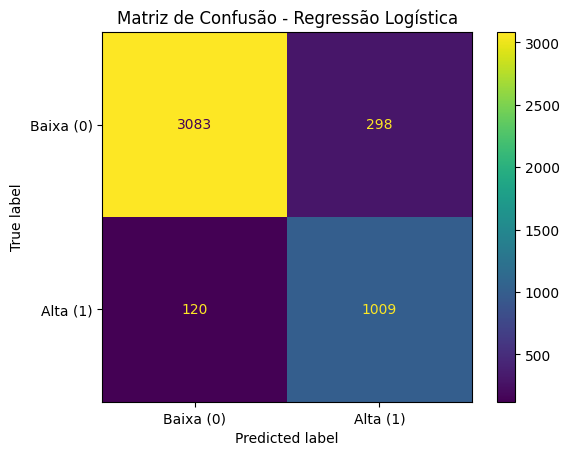

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

cm = np.array([[3083, 298],
               [120, 1009]])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Baixa (0)", "Alta (1)"]
)

plt.figure()
disp.plot(values_format="d")
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()


- Interpretação:

3083 verdadeiros negativos (TN): grupos de baixa adoção corretamente classificados como baixa adoção.

1009 verdadeiros positivos (TP): grupos de alta adoção corretamente identificados.

298 falsos positivos (FP): grupos de baixa adoção previstos como alta adoção.

120 falsos negativos (FN): grupos de alta adoção previstos como baixa adoção.

Observa-se que o modelo erra pouco em ambas as classes, com um número reduzido de falsos positivos e falsos negativos. Isso reforça que a regressão logística, combinada com o pré-processamento adequado, foi capaz de capturar padrões relevantes no perfil regional e demográfico associados à alta adoção de telemedicina.

- Conclusão:
O modelo apresentou desempenho excelente, com métricas superiores a 0,90 de accuracy e 0,96 de ROC-AUC. Esses resultados indicam que o problema proposto é previsível a partir das variáveis disponíveis, e que existe sinal consistente entre características demográficas/regionais e a probabilidade de alta adoção de telehealth. O próximo passo é comparar este baseline com modelos mais complexos (como Random Forest ou Gradient Boosting) para verificar se ainda há ganho de performance ou melhores interpretações de importância de variáveis.

### Modelo 2 — Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

rf = RandomForestClassifier(
    n_estimators=300,      # número de árvores
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

rf_model = Pipeline([
    ("preprocess", preprocess),
    ("model", rf)
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

metrics_rf = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "precision": precision_score(y_test, y_pred_rf),
    "recall": recall_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf),
    "roc_auc": roc_auc_score(y_test, y_proba_rf)
}

cm_rf = confusion_matrix(y_test, y_pred_rf)

metrics_rf, cm_rf


({'accuracy': 0.9483370288248337,
  'precision': 0.9242424242424242,
  'recall': 0.8644818423383526,
  'f1': 0.8933638443935927,
  'roc_auc': 0.9876410378531203},
 array([[3301,   80],
        [ 153,  976]]))

- Resultados do Random Forest:

Accuracy = 0,9483: cerca de 94,8% das previsões no teste foram corretas. Isso indica desempenho geral muito alto.

Precision = 0,9242: quando o modelo prevê alta adoção (1), ele acerta em aproximadamente 92,4% dos casos. Ou seja, há pouquíssimos falsos positivos.

Recall = 0,8645: o modelo identifica corretamente cerca de 86,4% dos grupos que realmente são alta adoção. Isso significa que alguns casos de alta adoção ainda são perdidos (falsos negativos), mas em quantidade moderada.

F1-score = 0,8934: valor alto, mostrando equilíbrio entre precisão muito forte e recall elevado.

ROC-AUC = 0,9876: desempenho praticamente perfeito na separação entre alta e baixa adoção, indicando que o modelo distingue muito bem as classes em diferentes limiares de decisão.

#### Matriz de confusão Random Forest

<Figure size 640x480 with 0 Axes>

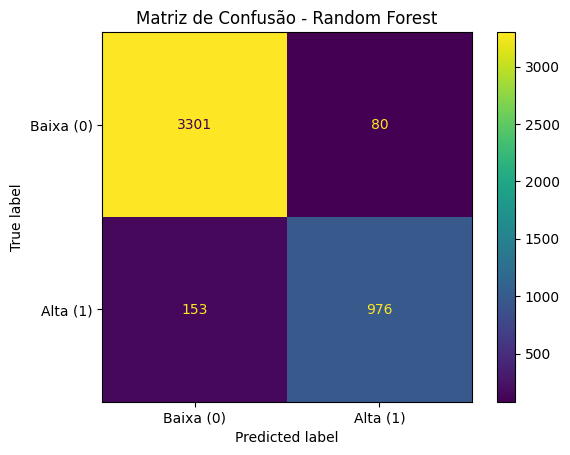

array([[3301,   80],
       [ 153,  976]])

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# matriz de confusão a partir das predições
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Baixa (0)", "Alta (1)"]
)

plt.figure()
disp.plot(values_format="d")
plt.title("Matriz de Confusão - Random Forest")
plt.show()

cm_rf


- Interpretação:

3301 verdadeiros negativos (TN): baixa adoção identificada corretamente.

976 verdadeiros positivos (TP): alta adoção identificada corretamente.

80 falsos positivos (FP): poucos grupos de baixa adoção foram confundidos como alta adoção.

153 falsos negativos (FN): alguns grupos reais de alta adoção foram classificados como baixa.

Essa matriz confirma o comportamento observado nas métricas: o modelo é extremamente preciso ao indicar alta adoção, errando pouco para cima, mas ainda perde uma parte dos casos positivos (FN).

- Comparação com a Regressão Logística:

A Regressão Logística já apresentava ótimo desempenho (accuracy ~0,91 e ROC-AUC ~0,96), mas o Random Forest superou em praticamente todos os aspectos:

aumento relevante de accuracy (0,91 → 0,95),

aumento muito forte de precision (≈0,77 → ≈0,92),

ROC-AUC ainda mais alto (≈0,96 → ≈0,99).

Assim, o Random Forest se mostrou o modelo mais adequado para o problema, por capturar relações não lineares e interações entre variáveis regionais e demográficas, reduzindo falsos positivos e aumentando a capacidade de separação entre grupos.

- Conclusão:
Os resultados indicam que é altamente possível prever alta adoção de telemedicina a partir de características regionais e demográficas. O Random Forest atingiu desempenho excelente e, portanto, é o candidato natural para ser o modelo final do projeto. Como etapa final, pode-se extrair a importância das variáveis para gerar insights sobre quais fatores mais influenciam a alta adoção.

### Feature Importance do Random Forest

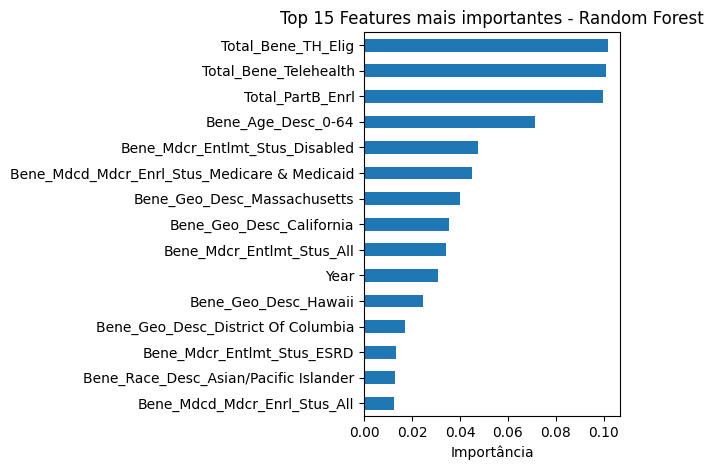

Total_Bene_TH_Elig                              0.101706
Total_Bene_Telehealth                           0.100979
Total_PartB_Enrl                                0.099662
Bene_Age_Desc_0-64                              0.071452
Bene_Mdcr_Entlmt_Stus_Disabled                  0.047601
Bene_Mdcd_Mdcr_Enrl_Stus_Medicare & Medicaid    0.045027
Bene_Geo_Desc_Massachusetts                     0.039985
Bene_Geo_Desc_California                        0.035572
Bene_Mdcr_Entlmt_Stus_All                       0.033962
Year                                            0.030597
Bene_Geo_Desc_Hawaii                            0.024387
Bene_Geo_Desc_District Of Columbia              0.016937
Bene_Mdcr_Entlmt_Stus_ESRD                      0.013294
Bene_Race_Desc_Asian/Pacific Islander           0.012776
Bene_Mdcd_Mdcr_Enrl_Stus_All                    0.012529
dtype: float64

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) pegar o OneHotEncoder que está dentro do pipeline
ohe = rf_model.named_steps["preprocess"].named_transformers_["cat"]

# 2) nomes das colunas geradas pelo One-Hot
ohe_features = ohe.get_feature_names_out(cat_cols)

# 3) lista final de features (one-hot + numéricas)
all_features = list(ohe_features) + num_cols

# 4) importância do Random Forest
importances = rf_model.named_steps["model"].feature_importances_

# 5) organizar em dataframe e pegar top 15
feat_imp = (
    pd.Series(importances, index=all_features)
    .sort_values(ascending=False)
    .head(15)
)

plt.figure()
feat_imp.sort_values().plot(kind="barh")
plt.title("Top 15 Features mais importantes - Random Forest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

feat_imp


- Análise:

Após o treinamento do Random Forest, foi analisada a importância das variáveis para entender quais fatores mais influenciam a previsão de alta adoção de telemedicina. As três features mais relevantes foram variáveis de escala populacional (Total_Bene_TH_Elig, Total_Bene_Telehealth e Total_PartB_Enrl), indicando que o tamanho dos grupos e o volume absoluto de usuários elegíveis/atendidos carregam forte sinal para distinguir alta e baixa adoção.

Entre os fatores demográficos, destacou-se a categoria etária 0–64, reforçando os resultados da EDA de que populações mais jovens apresentam maior probabilidade de pertencer ao grupo de alta adoção. Além disso, variáveis relacionadas ao status de elegibilidade clínica (Disabled, ESRD) e dupla elegibilidade (Medicare & Medicaid) também tiveram alta contribuição, sugerindo que perfis de saúde e cobertura influenciam o uso de telemedicina.

Do ponto de vista regional, estados específicos (ex.: Massachusetts, California, Hawaii e District of Columbia) surgiram como variáveis relevantes, evidenciando diferenças geográficas consistentes na chance de alta adoção. Por fim, o ano (Year) permaneceu entre as features importantes, refletindo o efeito temporal observado no período pós-2020.

Em conjunto, a importância das variáveis confirma que a alta adoção de telehealth é explicável por uma combinação de fatores populacionais, demográficos, clínicos e regionais, alinhando-se ao objetivo do projeto.